In [1]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    make_scorer,
    r2_score,
    mean_absolute_percentage_error as mape,
)
from sklearn.model_selection import (
    GridSearchCV,
    TimeSeriesSplit,
    cross_validate,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor

In [2]:
df = pd.read_csv("data/processed/most_crowded.csv")
df.tail(10)

,timestamp,crowd
909,1.713256e+09,219
910,1.713256e+09,214
911,1.713256e+09,216
912,1.713257e+09,202
913,1.713257e+09,235
914,1.713257e+09,226
915,1.713257e+09,260
916,1.713257e+09,251
917,1.713257e+09,233
918,1.713257e+09,93


## 1. Feature Extraction

1.1 Binning<br>
1.2. Lagged Features<br>
1.3. Rolling Mean Features<br>


##### Binning


In [3]:
mean_crowd = df["crowd"].mean()
std_crowd = df["crowd"].std()

# Define bins based on mean and standard deviation
bins = [
    float("-inf"),
    mean_crowd - 1.0 * std_crowd,
    mean_crowd - 0.5 * std_crowd,
    mean_crowd + 0.5 * std_crowd,
    mean_crowd + 1.0 * std_crowd,
    float("inf"),
]

# Define labels for the bins
labels = list(range(len(bins) - 1))

In [4]:
for i in range(len(bins) - 1):
    print(
        f"No. of values in bin {i + 1}: {df['crowd'].between(bins[i], bins[i + 1]).sum()}"
    )

No. of values in bin 1: 124
No. of values in bin 2: 178
No. of values in bin 3: 362
No. of values in bin 4: 120
No. of values in bin 5: 135


In [5]:
df["c_lvl"] = pd.cut(
    df["crowd"],
    bins=bins,
    labels=labels,
    include_lowest=True,
    ordered=True,
)

In [6]:
ts_date = pd.to_datetime(df["timestamp"], unit="s")

# Time-related features
time_related_features = {
    "hour": ts_date.dt.hour.astype(np.uint8),
    "day_of_week": ts_date.dt.day_of_week.astype(np.uint8),
    "minute": ts_date.dt.minute.astype(np.uint8),
    "is_weekend": (ts_date.dt.weekday >= 5).astype(np.uint8),
}

# Lagged features
lagged_features = {f"lag_{i}": df["crowd"].shift(i) for i in range(1, 11)}

# Rolling features
rolling_features = {
    f"rolling_{stat}_{window}": getattr(df["crowd"].rolling(window=window), stat)()
    for window in [5, 10, 15, 30]
    for stat in ["mean", "std", "min", "max", "sum"]
}

#### Lagged and Rolling Mean Features


In [7]:
lagged_df = (
    df.assign(**time_related_features, **lagged_features, **rolling_features)
    .drop(columns="crowd")
    .set_index("timestamp")
    .dropna()
)


lagged_df.tail(10)

,c_lvl,hour,day_of_week,minute,is_weekend,lag_1,lag_2,lag_3,lag_4,lag_5,...,rolling_mean_15,rolling_std_15,rolling_min_15,rolling_max_15,rolling_sum_15,rolling_mean_30,rolling_std_30,rolling_min_30,rolling_max_30,rolling_sum_30
timestamp,,,,,,,,,,,,,,,,,,,,,
1.713256e+09,4,8,1,30,0,194.0,214.0,229.0,239.0,255.0,...,222.200000,20.888137,194.0,266.0,3333.0,217.700000,18.416915,194.0,266.0,6531.0
1.713256e+09,4,8,1,32,0,219.0,194.0,214.0,229.0,239.0,...,223.200000,20.039960,194.0,266.0,3348.0,217.966667,18.299205,194.0,266.0,6539.0
1.713256e+09,4,8,1,33,0,214.0,219.0,194.0,214.0,229.0,...,223.600000,19.816299,194.0,266.0,3354.0,218.033333,18.287896,194.0,266.0,6541.0
1.713257e+09,3,8,1,35,0,216.0,214.0,219.0,194.0,214.0,...,223.400000,20.031404,194.0,266.0,3351.0,217.800000,18.451054,194.0,266.0,6534.0
1.713257e+09,4,8,1,37,0,202.0,216.0,214.0,219.0,194.0,...,224.266667,20.246575,194.0,266.0,3364.0,218.133333,18.674588,194.0,266.0,6544.0
1.713257e+09,4,8,1,39,0,235.0,202.0,216.0,214.0,219.0,...,225.800000,19.373030,194.0,266.0,3387.0,219.166667,18.202090,194.0,266.0,6575.0
1.713257e+09,4,8,1,41,0,226.0,235.0,202.0,216.0,214.0,...,229.266667,20.575529,194.0,266.0,3439.0,221.233333,19.207907,194.0,266.0,6637.0
1.713257e+09,4,8,1,43,0,260.0,226.0,235.0,202.0,216.0,...,230.600000,21.330059,194.0,266.0,3459.0,222.600000,19.829619,194.0,266.0,6678.0
1.713257e+09,4,8,1,45,0,251.0,260.0,226.0,235.0,202.0,...,230.200000,21.217244,194.0,266.0,3453.0,223.266667,19.831938,194.0,266.0,6698.0


## 4. Model Building


In [9]:
X = lagged_df.drop(columns=["c_lvl"])
y = lagged_df["c_lvl"]

In [10]:
cat_features = X.select_dtypes(include="category").columns.tolist()
num_features = X.select_dtypes(include="int").columns.tolist()

Feature Importance


In [11]:
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor


estimator = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
estimator.fit(X, y)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [15]:
sorted(estimator.feature_importances_, reverse=True)

[0.343702924818127,
 0.1321415465108361,
 0.11889221700115056,
 0.04616835289483231,
 0.04100122393743003,
 0.03943273737887946,
 0.0334329246851811,
 0.029248838382344874,
 0.01663116264019573,
 0.016474207269674874,
 0.014473342627164982,
 0.01433764280561638,
 0.01261496423577936,
 0.01258099188621915,
 0.012259321230815934,
 0.012251933190367402,
 0.011580444880228635,
 0.010516804556840561,
 0.010237009935747185,
 0.00969016583978468,
 0.009090393328326325,
 0.006132443477901721,
 0.005407119693771087,
 0.005405829886187806,
 0.005385158342315018,
 0.00532663116357807,
 0.005088680287617302,
 0.004840368812701916,
 0.004490747507127724,
 0.0038159118675774343,
 0.003560235268162222,
 0.003399792221864896,
 0.0003879314356521041,
 0.0]

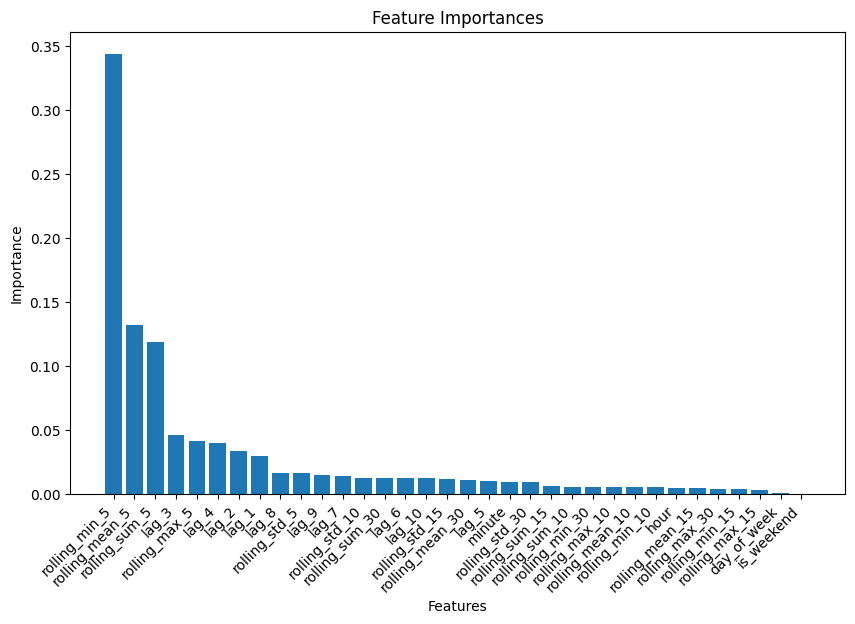

In [18]:
feature_importances = estimator.feature_importances_
names = X.columns.values

features = list(zip(names, feature_importances))
sorted_features = sorted(features, key=lambda x: x[1], reverse=True)
sorted_names, sorted_importances = zip(*sorted_features)


plt.figure(figsize=(10, 6))
ticks = np.arange(len(sorted_names))
plt.bar(ticks, sorted_importances)
plt.xticks(ticks, sorted_names, rotation=45, ha="right")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances")
plt.show()

1. Pipeline Construction
2. Time Series Cross Validation


In [19]:
feature_cats = [sorted(X[feature].unique().tolist())
                for feature in cat_features]
target_cats = sorted(y.unique().tolist())

In [20]:
preprocessor = ColumnTransformer(
    [
        ("num", MinMaxScaler(), num_features),
    ],
    remainder="passthrough",
    verbose=False,
)

pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "estimator",
            XGBRegressor(
                objective="reg:squarederror",
                tree_method="hist",
                max_depth=2,
                n_estimators=50,
                learning_rate=0.01,
                reg_lambda=0.5,
                n_jobs=-1,
            ),
        ),
    ],
    verbose=False,
)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(), [])])),
                ('estimator',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=N...ne, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.01,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=2, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=50, n_jobs=-1,
                              num_parallel_tree=None, random_state=None, ...))])

In [21]:
param_grid = {
    "estimator__n_estimators": [50, 100, 200],
    "estimator__max_depth": [2, 3, 5],
    "estimator__learning_rate": [0.01, 0.05, 0.1],
    "estimator__subsample": [0.5, 0.7, 0.8],
    "estimator__colsample_bytree": [0.5, 0.7, 0.8],
}

In [22]:
ts_cv = TimeSeriesSplit(n_splits=5)

##### Grid Search


In [23]:
scoring = {
    "MAPE": make_scorer(mape),
    "R2": make_scorer(r2_score),
}

In [24]:
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=ts_cv,
    scoring=scoring,
    refit="R2",
    n_jobs=1,
    verbose=1,
)
grid_search.fit(X, y)

print(f"Best score: {grid_search.best_score_:.3f}")
print(f"Best parameters:")
for key, value in grid_search.best_params_.items():
    print(f"    - {key.split('__')[-1]}: {value}")

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


In [30]:
model = grid_search.best_estimator_

colsample_bytree: 0.8
learning_rate: 0.05
max_depth: 3
n_estimators: 200
subsample: 0.5


In [25]:
cv_results = cross_validate(
    model,
    X,
    y,
    cv=ts_cv,
    scoring=scoring,
    n_jobs=1,
)

In [26]:
for key, value in cv_results.items():
    if key.startswith("test"):
        metric = key.split("_")[1]
        print(f"{metric}: {value.mean():.3f} ± {value.std():.3f}")

MAPE: 669313423639945.125 ± 495065015878139.125
R2: 0.511 ± 0.092
